In [1]:
import csv        
import torch
import pandas as pd
from PIL import Image
from io import BytesIO
import base64
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"]="1"

/home/jhkim/anaconda3/envs/ofa/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


.pth to .tsv

### .pth
- [obj1_dict, obj2_dict, ...]
- objn_dict =  {
            'visual feature': datas,
		    'category' : category,
		    'label' : "",
		    'known' : None,
		    'labelled' : None,
			'img_id' : str
			'obj_id': str
             }

In [2]:
    # V structure
        # data['interaction'] = True
        # data['img_id'] = inter_obj_key   # 0, 1, 2, ...       
        # data['object_id'] = inter_obj_key     # 0_0.png, ...
        # data['category'] = personal_q
        # data['visual feature'] = feat
        # data['known'] = True
        # data['labelled'] = True
        # data['label'] = personal_q

### Baseline2 (Passive)
- only using one annotated data per object
- Just Teach
### ours1 (Curious)
- only using the annotated Train dataset
- Teach + Object Inspection
### orus2 (Propagation)
- Curious + LP
### ours3 (GPT)
- Propagation + GPT
### baseline5 (GT)
- Fully annotated Train dataset

## Check if label propagation is valid

In [3]:
# pth_path = '/data/jhkim/icra24/ofa_vg_data/lp_vanilla_0.55_400sampled.pth'
# data = torch.load(pth_path)
# tot = 0 #from raw images
# cnt = 0
# cnt_labelled = 0
# for d in data:
#     if d['category'] not in ['line','vague']:
#         if d['interaction'] == False:
#             tot += 1
#             if d['label'].strip() == d['category'].strip():
#                 cnt += 1
#             if d['labelled']:
#                 cnt_labelled += 1
# print(cnt)
# print(cnt/cnt_labelled)
# print(tot)

In [4]:
# pth_path = '/data/jhkim/icra24/ofa_vg_data/lp_vanilla_0.55_400sampled_ignore_from2.pth'

# json_path = '/home/jhkim/icra24/vis_feature/cropped_DINO_feat.json'
# interact_json_path = '/home/jhkim/icra24/interactive/interactive_perQ_bbox.json' #{'0.png':[perQ, bbox], ...}

# raw_image_path = '/data/jhkim/icra24/raw_images/train/'
# raw_inter_image_path = '/data/jhkim/icra24/raw_images/interaction/'
# curious_tsv_path = '/data/jhkim/icra24/ofa_vg_data/ofa_train_tsv/curious_ignore_from2.tsv'
# passive_tsv_path = '/data/jhkim/icra24/ofa_vg_data/ofa_train_tsv/passive_ignore_from2.tsv'
# propagation_tsv_path = '/data/jhkim/icra24/ofa_vg_data/ofa_train_tsv/propagation_ignore_from2.tsv'
# gpt_tsv_path = '/data/jhkim/icra24/ofa_vg_data/ofa_train_tsv/gpt_ignore_from2.tsv'
# gpt_json_path = '/home/jhkim/icra24/ChatGPT/gpt.json'
# gt_tsv_path = '/data/jhkim/icra24/ofa_vg_data/ofa_train_tsv/gt_ignore_from2.tsv'

# data = torch.load(pth_path)
# with open(json_path, 'r') as f:
#     json_data = json.load(f)
# with open(interact_json_path, 'r') as f:
#     interact_json_data = json.load(f)
# with open(gpt_json_path, 'r') as f:
#     gpt_data = json.load(f)

# print('number of data = {}'.format(len(data)))

# curious_cnt = 0 # propagation - interaction
# passive_cnt = 0
# propagation_cnt = 0
# gpt_cnt = 0
# gt_cnt = 0
# with open(gt_tsv_path, 'w', newline='') as f_gt:
#     gt_tsv_output = csv.writer(f_gt, delimiter='\t')
#     with open(gpt_tsv_path, 'w', newline='') as f_gpt:
#         gpt_tsv_output = csv.writer(f_gpt, delimiter='\t')
#         with open(passive_tsv_path, 'w', newline='') as f_passive:
#             passive_tsv_output = csv.writer(f_passive, delimiter='\t')
#             with open(curious_tsv_path, 'w', newline='') as f_curious:
#                 curious_tsv_output = csv.writer(f_curious, delimiter='\t')
#                 with open(propagation_tsv_path, 'w', newline='') as f_output:
#                     propagation_tsv_output = csv.writer(f_output, delimiter='\t')
#                     for indx, sample in enumerate(data):
#                         # if gt_cnt > 100 and gt_cnt < 110:
#                         #     print(f'!!!{sample}')
#                         img_id = sample['img_id']
#                         # if '_' in img_id: #ignore the data from interactive
#                         #     continue
#                         object_id = sample['object_id']
#                         use = []
#                         use.append(propagation_cnt)
#                         use.append(img_id)
#                         use.append(sample['label']) #Q
#                         # print('{}'.format(sample['label']))
#                         if sample['interaction'] == False:
#                             bbox = json_data[img_id][object_id][1]
#                             use.append("{},{},{},{}".format(bbox[0],bbox[1],bbox[2],bbox[3])) #bbox
#                             img = Image.open(os.path.join(raw_image_path, img_id))
#                         else:
#                             bbox = interact_json_data[object_id][1]
#                             use.append("{},{},{},{}".format(bbox[0],bbox[1],bbox[2],bbox[3])) #bbox
#                             img = Image.open(os.path.join(raw_inter_image_path, img_id))
#                         img_buffer = BytesIO()
#                         img.save(img_buffer, format=img.format)
#                         byte_data = img_buffer.getvalue()
#                         base64_str = base64.b64encode(byte_data) # bytes
#                         base64_str = base64_str.decode("utf-8") # str
#                         use.append(base64_str)
#                         gtuse = use.copy()
#                         gtuse[2] = sample['category']
#                         gtuse[0] = gt_cnt
#                         gt_tsv_output.writerow(gtuse)
#                         gt_cnt += 1
#                         if sample['labelled'] == True:
#                             propagation_tsv_output.writerow(use)
#                             propagation_cnt += 1
#                             if '_' not in img_id:
#                                 curioususe = use.copy()
#                                 curioususe[0] = curious_cnt
#                                 curious_tsv_output.writerow(curioususe)
#                                 curious_cnt += 1                                
#                             if sample['known'] == True:
#                                 # curioususe = use.copy()
#                                 # curioususe[0] = curious_cnt
#                                 # curious_tsv_output.writerow(curioususe)
#                                 # curious_cnt += 1
#                                 if '_' not in img_id:
#                                     passiveuse = use.copy()
#                                     passiveuse[0] = passive_cnt
#                                     passive_tsv_output.writerow(passiveuse)
#                                     passive_cnt += 1
#                             paraphrased = gpt_data[sample['label']]
#                             gptuse = use.copy()
#                             gptuse[0] = gpt_cnt
#                             gpt_tsv_output.writerow(gptuse)
#                             gpt_cnt += 1
#                             for pra in paraphrased:
#                                 gptuse = use.copy()
#                                 gptuse[2] = pra
#                                 gptuse[0] = gpt_cnt
#                                 gpt_tsv_output.writerow(gptuse)
#                                 gpt_cnt += 1
#                         if indx%500 == 0:
#                             print("{} processing ... {}%".format(pth_path, int(100*indx/len(data))))

# print("number of utilized triplets")
# print(f'passive: {passive_cnt}')
# print(f'curious: {curious_cnt}')
# print(f'propagation: {propagation_cnt}')
# print(f'gpt: {gpt_cnt}')
# print(f'gt: {gt_cnt}')

# For 100,200,300 and seed 666, 777, 888

In [2]:
samples = [25]
seeds = [666,777,888]

for sample_n in samples:
    print(sample_n)
    for seed in seeds:
        print(seed)
        pth_path = '/data/jhkim/icra24/ofa_vg_data/lp_vanilla_0.55_{}sampled_{}_ignore_from2.pth'.format(sample_n, seed)

        json_path = '/home/jhkim/icra24/vis_feature/cropped_DINO_feat.json'
        interact_json_path = '/home/jhkim/icra24/interactive/interactive_perQ_bbox.json' #{'0.png':[perQ, bbox], ...}
        raw_image_path = '/data/jhkim/icra24/raw_images/train/'
        raw_inter_image_path = '/data/jhkim/icra24/raw_images/interaction/'

        propagation_tsv_path = '/data/jhkim/icra24/ofa_vg_data/ofa_train_tsv/propagation_ignore_from2_{}_seed_{}.tsv'.format(sample_n,seed)

        data = torch.load(pth_path)
        with open(json_path, 'r') as f:
            json_data = json.load(f)
        with open(interact_json_path, 'r') as f:
            interact_json_data = json.load(f)

        print('number of data = {}'.format(len(data)))

        propagation_cnt = 0

        with open(propagation_tsv_path, 'w', newline='') as f_output:
            propagation_tsv_output = csv.writer(f_output, delimiter='\t')
            for indx, sample in enumerate(data):
                img_id = sample['img_id']
                object_id = sample['object_id']
                use = []
                use.append(propagation_cnt)
                use.append(img_id)
                use.append(sample['label']) #Q
                # print('{}'.format(sample['label']))
                if sample['interaction'] == False:
                    bbox = json_data[img_id][object_id][1]
                    use.append("{},{},{},{}".format(bbox[0],bbox[1],bbox[2],bbox[3])) #bbox
                    img = Image.open(os.path.join(raw_image_path, img_id))
                else:
                    bbox = interact_json_data[object_id][1]
                    use.append("{},{},{},{}".format(bbox[0],bbox[1],bbox[2],bbox[3])) #bbox
                    img = Image.open(os.path.join(raw_inter_image_path, img_id))
                img_buffer = BytesIO()
                img.save(img_buffer, format=img.format)
                byte_data = img_buffer.getvalue()
                base64_str = base64.b64encode(byte_data) # bytes
                base64_str = base64_str.decode("utf-8") # str
                use.append(base64_str)
                if sample['labelled'] == True:
                    propagation_tsv_output.writerow(use)
                    propagation_cnt += 1                           

        print("number of utilized triplets")
        print(f'propagation: {propagation_cnt}')

25
666
number of data = 729
number of utilized triplets
propagation: 523
777
number of data = 748
number of utilized triplets
propagation: 559
888
number of data = 770
number of utilized triplets
propagation: 576


# Visualize and Check .tsv

In [6]:
import sys
from PIL import Image
import cv2
import numpy

csv.field_size_limit(sys.maxsize)
img_dir_path = '/data/jhkim/icra24/raw_images/train/'
gt_tsv_path = '/data/jhkim/icra24/ofa_vg_data/ofa_train_tsv/gt.tsv'

with open(gt_tsv_path, 'r', newline='') as f:
    reader = csv.reader(f, delimiter='\t')
    rows = list(reader)
print(len(rows))

8763


['369', '89.png', 'my plushie, Ruby', '208.14962768554688,276.60821533203125,309.48138427734375,372.8480529785156']


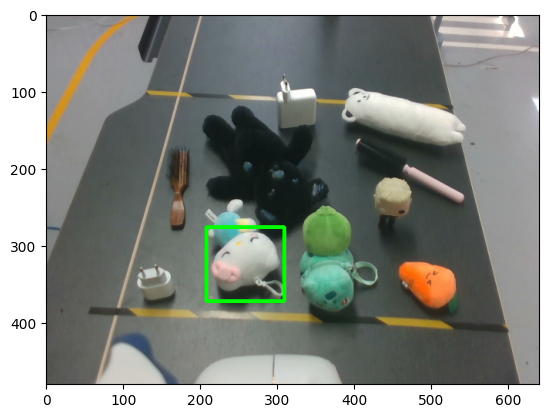

In [7]:
id = 369 #index to show

print(rows[id][:4])
row = rows[id]

img_path = os.path.join(img_dir_path, row[1])
text = row[2]
bbox = [float(i) for i in row[3].split(',')]

image = Image.open(img_path)

img = cv2.cvtColor(numpy.asarray(image), cv2.COLOR_RGB2BGR)
cv2.rectangle(
    img,
    (int(bbox[0]), int(bbox[1])),
    (int(bbox[2]), int(bbox[3])),
    (0, 255, 0),
    3
)
#print(result[0]["box"])

from matplotlib import pyplot as plt
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

# Make test .tsv

In [8]:
# test_ann_path = '/data/jhkim/icra24/ofa_vg_data/test_annotation/'
# seen_rand_pth_path = test_ann_path + 'seen_random.pth' # [[img_id, q_id, indicator, bbox], ...]
# unseen_rand_pth_path = test_ann_path + 'unseen_random.pth' # [[img_id, q_id, indicator, bbox], ...]
# seen_same_pth_path = test_ann_path + 'seen_same.pth' # [[img_croid, q_id, indicator, bbox], ...]
# unseen_same_pth_path = test_ann_path + 'unseen_same.pth' # [[img_id, q_id, indicator, bbox], ...]
# paraphrased_pth_path = test_ann_path + ''
# cluttered_pth_path = test_ann_path + 'cluttered.pth'

# seen_rand = torch.load(seen_rand_pth_path)
# unseen_rand = torch.load(unseen_rand_pth_path)
# seen_same = torch.load(seen_same_pth_path)
# unseen_same = torch.load(unseen_same_pth_path)
# cluttered = torch.load(cluttered_pth_path)

# raw_image_path = '/data/jhkim/icra24/raw_images/test/seen_random'
# tsv_path = '/data/jhkim/icra24/ofa_vg_data/ofa_train_tsv/validation.tsv'


# with open(tsv_path, 'w', newline='') as f_output:
#     tsv_output = csv.writer(f_output, delimiter='\t')
#     for indx, sample in enumerate(seen_rand.tolist()):
#         img_id = sample[0]
#         object_id = sample[1]
#         use = []
#         use.append(indx)
#         use.append(img_id)
#         use.append(sample[2]) #Q
#         bbox = sample[3]
#         use.append("{},{},{},{}".format(bbox[0],bbox[1],bbox[2],bbox[3])) #bbox
#         img = Image.open(os.path.join(raw_image_path, img_id))
#         img_buffer = BytesIO()
#         img.save(img_buffer, format=img.format)
#         byte_data = img_buffer.getvalue()
#         base64_str = base64.b64encode(byte_data) # bytes
#         base64_str = base64_str.decode("utf-8") # str
#         use.append(base64_str)
#         tsv_output.writerow(use)
            
#         if indx%12 == 0:
#             print("{} processing ... {}%".format(pth_path, int(100*indx/len(data))))